# Homework #2: train a CTC speech recognition model

In lecture you have examined the basics of speech recognition and covered the Connectionist Temporal Classification (CTC) model in detail. You are now ready to train your first "adult" speech recognition system!

In seminar 2 you implemented the CTC forward and backward algorithms in order to calculate the CTC loss and study the diffusion of probability in a CTC trellis. Also you implemented a greedy decoder and a prefix beam-search decoder

In this homework you will implement and train a CTC speech recognition model on a subset of the LibriSpeech corpus. This task will involve:

- Creating a dataloader
- Implementing a and training a Neural Network for CTC
  * DNN
  * LSTM
  * BiLSTM
- Comparing the Properties of these models

I need to mention that as I trained the model on my laptop so I've made some changes in the code: 

- Modified library versions and device name due to CUDA compatibility and system specifications.
- Adjusted kwargs in loaders to match my system configuration.
- Updated the Collate function to support GPU training.
- Introduced n_mels as a variable to ensure consistency in hyperparameters and MelSpectrogram calls.
- Modified the test function to control testing process.
- Enhanced the save_checkpoint function to save optimizer state in addition to model weights.
- Utilized CharErrorRate and WordErrorRate from torchmetrics for faster computation.
- Incorporated changes from GitHub repositories to improve the classifier in CTCBiRNN and CTCRNN and to debug the problems.

[GitHub repo 1](https://github.com/MorrisXu-Driving/Improving_DeepSpeech_2_by_RNN_Transducer_Pytorch_Implementation/blob/a663aeb422be393fbb9f813500222f16b9c80aab/Deep%20Speech%202.py)

[GitHub repo 2](https://github.com/grazder/speech_course/blob/4a07c2df715320c79e87d20aae0050efbf42cde2/week_05/homework2_student.ipynb)

Also I used ChatGPT and BraveAI to resolve the issues I encountered.

# Setup - Install package, download files, etc...

In [1]:
# uncomment if needed. If you run the notebook in Colab, all these libraries are pre-installed
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install numpy==1.17.5 matplotlib==3.3.3 tqdm==4.54.0

In [2]:
# !pip install arpa

In [3]:
# %%capture
# !pip install wandb -qqq

In [4]:
#!L
import math
import os
import shutil
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable

import arpa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import wandb
from matplotlib.colors import LogNorm
from torch import optim
from tqdm.notebook import tqdm
import time
from torch.optim.lr_scheduler import OneCycleLR
import torch.multiprocessing as mp

In [5]:
import utils as utils   # Change relative path if needed

# Seminar 2 recap: CTC Forward-Backward Algorithm + Soft alignment

## CTC Forward Algorithm

In [6]:
# Helper functions
BLANK_SYMBOL = "_"

class Tokenizer:
    """
    Maps characters to integers and vice versa
    """
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for i, ch in enumerate(["'", " "] + list(string.ascii_lowercase) + [BLANK_SYMBOL]):
            self.char_map[ch] = i
            self.index_map[i] = ch
        
    def text_to_indices(self, text: str) -> List[int]:
        return [self.char_map[ch] for ch in text]

    def indices_to_text(self, labels: List[int]) -> str:                                                                                                                                                                                                                                 
        return "".join([self.index_map[i] for i in labels])
    
    def get_symbol_index(self, sym: str) -> int:
        return self.char_map[sym]
    

tokenizer = Tokenizer()

NEG_INF = -float("inf")


def logsumexp(*args) -> float:
    """
    Log-sum-exp trick for log-domain calculations
    See for details: https://en.wikipedia.org/wiki/LogSumExp
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max) for a in args))
    return a_max + lsp


def modify_sequence(sequence: List[int], blank_idx: int) -> List[int]:
    """
    Modifies sequence which with START, END blanks and between each character
    """
    modified_sequence = []
    
    for idx in sequence:
        modified_sequence += [blank_idx, idx]
        
    modified_sequence.append(blank_idx)
    return modified_sequence

In [7]:
#!L

def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)
    
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)

    # Initialze
    # (2L + 1) x T 
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            # First Step
            ch = mod_sequence[s]
            if t == 0:
                if s != 0 and s != 1:
                    alphas[s][t] = NEG_INF
                else:
                    alphas[s][t] = matrix[ch][t]
                
            # Upper diagonal zeros
            elif s < alphas.shape[0] - 2 * (alphas.shape[1]-t)-1:# CONDITION
                alphas[s][t] = NEG_INF
            else:
                # Need to do this stabily
                if s == 0:
                    alphas[s][t] = alphas[s][t-1] + matrix[ch][t]
                elif s == 1:
                    alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s-2]:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1]) + matrix[ch][t]
                    else:
                        alphas[s][t] = logsumexp(alphas[s][t-1], alphas[s-1][t-1], alphas[s-2][t-1]) + matrix[ch][t]
    return alphas

## The CTC Backward Algorithm

In [8]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = modify_sequence(sequence, blank)
    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            # First Step
            ch = mod_sequence[s]
            if t == matrix.shape[1] - 1:
                if s == betas.shape[0]-1 or s == betas.shape[0]-2:
                    betas[s][t] = 0

            # Lower Diagonal Zeros
            elif s > 2 * t + 1:# CONDITION
                betas[s][t] = NEG_INF
            else:
                if s == len(mod_sequence) - 1:
                    betas[s][t] = betas[s][t+1] + matrix[ch][t]
                elif s == len(mod_sequence) - 2:
                    betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                else:
                    if ch == blank or ch == mod_sequence[s + 2]:
                            betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1]) + matrix[ch][t]
                    else:                
                        betas[s][t] = logsumexp(betas[s][t+1], betas[s+1][t+1], betas[s+2][t+1]) + matrix[ch][t]
    return betas

## Soft-Alignment


In [9]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas + betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0)

    return align

## Greedy Best-Path Decoder


In [10]:
#!L
def greedy_decoder(output: torch.Tensor, labels: List[torch.Tensor], 
                   label_lengths: List[int], collapse_repeated: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: list of label indices converted to torch.Tensors
    :param label_lengths: list of label lengths (without padding)
    :param collapse_repeated: whether the repeated characters should be deduplicated
    :return: the result of the decoding and the target sequence
    """
    blank_label = tokenizer.get_symbol_index(BLANK_SYMBOL)

    # Get max classes
    ########################
    arg_maxes = output.argmax(dim=-1)
    ########################

    decodes = []
    targets = []

    # For targets and decodes remove repeats and blanks
    for i, args in enumerate(arg_maxes):
        decode = []
        true_labels = labels[i][:label_lengths[i]].tolist()
        targets.append(tokenizer.indices_to_text(true_labels))

        # Remove repeats, then remove blanks
        for j, index in enumerate(args):
            ########################
            if j != 0:
                if index == args[j-1]:
                    continue
            decode.append(int(index.cpu().detach()))    
            ########################
        ####
        decode = [x for x in decode if x != blank_label]
        ######
        
        decodes.append(tokenizer.indices_to_text(decode))
    return decodes, targets

## Prefix Decoding With LM

In [11]:
LanguageModel = TypeVar("LanguageModel")
# Helper function

class Beam:
    def __init__(self, beam_size: int) -> None:
        self.beam_size = beam_size
        
        fn = lambda : (NEG_INF, NEG_INF)
        
        # Store probs key - prefix, value - p_blank, p_not_blank for ? step
        self.candidates = defaultdict(fn)
        
        # Store sorted by cumulative probability self.candidates
        self.top_candidates_list = [
            (
                tuple(), 
                (0.0, NEG_INF) # log(p_blank) = 0, log(p_not_blank) = -inf
            )
        ]
        
    def get_probs_for_prefix(self, prefix: Tuple[int]) -> Tuple[float, float]:
        p_blank, p_not_blank = self.candidates[prefix]
        return p_blank, p_not_blank
        
    def update_probs_for_prefix(self, prefix: Tuple[int], next_p_blank: float, next_p_not_blank: float) -> None:
        self.candidates[prefix] = (next_p_blank, next_p_not_blank)
        
    def update_top_candidates_list(self) -> None:
        top_candidates = sorted(
            self.candidates.items(), 
            key=lambda x: logsumexp(*x[1]), 
            reverse=True
        )
        self.top_candidates_list = top_candidates[:self.beam_size]
        

def calculate_probability_score_with_lm(lm: LanguageModel, prefix: str) -> float:
    text = tokenizer.indices_to_text(prefix).upper().strip()    # Use upper case for LM and remove the trailing space
    lm_prob = lm.log_p(text)             
    score = lm_prob / np.log10(np.e)    # Convert to natural log, as ARPA LM uses log10   
    return score

In [12]:
#!L

def decode(probs: np.ndarray, beam_size: int = 5, lm: Optional[LanguageModel] = None, 
           prune: float = 1e-5, alpha: float = 0.1, beta: float = 2):
    """
    :param probs: A matrix of shape (T, K) with probability distributions over phonemes at each moment of time.
    :param beam_size: the size of beams
    :lm: arpa language model
    :prune: the minimal probability for a symbol at which it can be added to a prefix
    :alpha: the parameter to de-weight the LM probability
    :beta: the parameter to up-weight the length correction term
    :return: the prefix with the highest sum of probabilites P_blank and P_not_blank
    """
    T, S = probs.shape
    probs = np.log(probs)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    space = tokenizer.get_symbol_index(" ")
    prune = NEG_INF if prune == 0.0 else np.log(prune)
    
    beam = Beam(beam_size)
    # Итерируемся по оси времени
    for t in range(T):
        next_beam = Beam(beam_size)
        
        # Итерируемся по символам
        for s in range(S):
            p = probs[t, s]
            # Prune the vocab - пропускаем символ, если вероятность оказаться в нем слишком мала на t-м щаге
            if p < prune:   
                continue
            
            # Итерируемся по варинатам, в которые можем пойти из текущего символа
            # Сначала идут наиболее вероятные по сумме log(p_blank + p_not_blank) префиксы
            # (p_blank, p_not_blank) - вероятности на предыдущем t-1 шаге
            for prefix, (p_blank, p_not_blank) in beam.top_candidates_list:
                # Текущий символ - бланк 
                if s == blank:
                    # вероятности на текущем шаге
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=logsumexp(p_b, p_blank + p, p_not_blank + p),
                        next_p_not_blank=p_nb
                    )
                    continue

                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                
                # Повторяющийся символ
                if s == end_t:
                    # Предыдущий символ - бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_blank)
                    )
                    # Предыдущий символ не бланк
                    p_b, p_nb = next_beam.get_probs_for_prefix(prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p + p_not_blank)
                    )
                elif s == space and end_t is not None and lm is not None:
                    # Символ - пробел и не первый, нужно применить языковую модель
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    score = calculate_probability_score_with_lm(lm, n_prefix)
                    length = len(tokenizer.indices_to_text(prefix))
                    
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,         
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(
                            p_nb,
                            p_blank + p + score * alpha + np.log(length) * beta,
                            p_not_blank + p + score * alpha + np.log(length) * beta
                        )  
                    )
                else:
                    p_b, p_nb = next_beam.get_probs_for_prefix(n_prefix)
                    next_beam.update_probs_for_prefix(
                        prefix=n_prefix,
                        next_p_blank=p_b,
                        next_p_not_blank=logsumexp(p_nb, p_blank + p, p_not_blank + p)
                    )

        next_beam.update_top_candidates_list()
        beam = next_beam

    best = beam.top_candidates_list[0]
    return best[0], -logsumexp(*best[1])


def beam_search_decoder(probs: np.ndarray, labels: List[List[int]], label_lengths: List[int], 
                        input_lengths: List[int], lm: LanguageModel, beam_size: int = 5,
                        prune: float = 1e-3, alpha: float = 0.1, beta: float = 0.1):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    
    for i, prob in enumerate(probs):
        targets.append(tokenizer.indices_to_text(labels[i][:label_lengths[i]].tolist()))
        int_seq, _ = decode(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, prune=prune, alpha=alpha, beta=beta)
        decodes.append(tokenizer.indices_to_text(int_seq))
        
    return decodes, targets

# Homework 2 starts here: CTC Speech Recognition System
You can do this notebook in google collab, or use other GPU sources

### Tasks

- (25 points) Train ASR System, WER criterions: 60-50 -- 9 points, 50-40 -- 15 points, 40-35 -- 20 points, <=35 -- 25 points. + 1 bonus point per 1% WER below 30
- (2 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
- (3 points) Compare alignments obtained from DNN, RNN and BiRNN models

## Implementing, training and evaluationg your CTC ASR model

### Create a Dataloader

The first step is to create a dataloader to download and load and preprocess LibriSpeech acoustic data. 

The creative options you have at this stage are:

* The sample rate and number of mel-bins.
* Various forms of data agumentation

In [13]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

In [1]:
from torchaudio.transforms import MelSpectrogram, MFCC

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_mels = 128

#!L
# For train you can use SpecAugment data aug here.
train_audio_transforms = nn.Sequential(
    #Add features transformations here
    MelSpectrogram(sample_rate=16000, n_mels=n_mels),
    #Can add data augmentation here!
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
).to(device)

test_audio_transforms = nn.Sequential(
    #Add feature transformations here
    MelSpectrogram(sample_rate=16000, n_mels=n_mels),
).to(device)

In [15]:
class Collate:
    def __init__(self, data_type = 'test') -> None:
        super(Collate, self).__init__() 

        self.data_type = data_type

    def __call__(self, data: torchaudio.datasets.librispeech.LIBRISPEECH) -> Tuple[List[torch.Tensor], ...]:
        """
        :param data: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """
        spectrograms = []
        labels = []
        input_lengths = []
        label_lengths = []
        for (waveform, _, utterance, _, _, _) in data:
            if self.data_type == 'train':
                # spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
                spec = train_audio_transforms(waveform.to(device)).squeeze(0).transpose(0, 1)
            elif self.data_type == 'test':
                # spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
                spec = test_audio_transforms(waveform.to(device)).squeeze(0).transpose(0, 1)
            else:
                raise Exception('data_type should be train or valid')
            spectrograms.append(spec)
            label = torch.Tensor(tokenizer.text_to_indices(utterance.lower()))
            labels.append(label)
            input_lengths.append(spec.shape[0] // 2)
            label_lengths.append(len(label))
            
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

        return spectrograms, labels, input_lengths, label_lengths


### Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 9 points, 50-40 -- 15 points, 40-35 -- 20 points, <= 35 -- 25 points

In [16]:
#!L

# Our model classes are just examples, you can change them as you want

# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats: int) -> None:
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
        https://github.com/MorrisXu-Driving/Improving_DeepSpeech_2_by_RNN_Transducer_Pytorch_Implementation/blob/a663aeb422be393fbb9f813500222f16b9c80aab/Deep%20Speech%202.py#L267
    """

    def __init__(self, in_channels: int, out_channels: int, kernel: int, stride: int, dropout: float, n_feats: int) -> None:
        super(ResidualCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel, stride=stride, padding=kernel // 2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel, stride=stride, padding=kernel // 2)
        self.layer_norm = CNNLayerNorm(n_feats)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x  # (batch, channel, feature, time)
        x = self.conv1(self.dropout(F.gelu(self.layer_norm(x))))
        x = self.conv2(self.dropout(F.gelu(self.layer_norm(x))))
        x += residual
        return x  # (batch, channel, feature, time)



class FeatureExtractor(nn.Module):
    """https://github.com/MorrisXu-Driving/Improving_DeepSpeech_2_by_RNN_Transducer_Pytorch_Implementation/blob/a663aeb422be393fbb9f813500222f16b9c80aab/Deep%20Speech%202.py#L315
    """
    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int,
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(FeatureExtractor, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3 // 2)  # cnn for extracting hierarchical features
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats * 32, rnn_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        return x


class CTCDNN(nn.Module):
    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCDNN, self).__init__()
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                                                  n_feats, stride, dropout)
        self.intermediate_layers = nn.Sequential(
            nn.Linear(rnn_dim, rnn_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim * 2, rnn_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(rnn_dim * 2, n_class)

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.intermediate_layers(x)
        x = self.classifier(x)
        return x


class CTCRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCRNN, self).__init__()

        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                        n_feats, stride, dropout)
        lstm_layers = [
            nn.LSTM(input_size=rnn_dim if i == 0 else rnn_dim,
                    hidden_size=rnn_dim,
                    num_layers=1,
                    bidirectional=False,
                    batch_first=True)
            for i in range(n_rnn_layers)
        ]
        
        self.intermediate_layers = nn.Sequential(*lstm_layers)
        # self.classifier = nn.Linear(rnn_dim, n_class)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        for lstm_layer in self.intermediate_layers:
            x, _ = lstm_layer(x)
        x = self.classifier(x)
        return x


class CTCBiRNN(nn.Module):

    def __init__(self, n_cnn_layers: int, n_rnn_layers: int, rnn_dim: int, n_class: int, 
                 n_feats: int, stride: int = 2, dropout: float = 0.1) -> None:
        super(CTCBiRNN, self).__init__()
        
        self.feature_extractor = FeatureExtractor(n_cnn_layers, n_rnn_layers, rnn_dim,
                 n_feats, stride, dropout)
        lstm_layers = [
            nn.LSTM(input_size=rnn_dim if i == 0 else 2 * rnn_dim,
                    hidden_size=rnn_dim,
                    num_layers=1,
                    bidirectional=True,
                    batch_first=True)
            for i in range(n_rnn_layers)
        ]
        self.intermediate_layers = nn.Sequential(*lstm_layers)
        # self.classifier = nn.Linear(2*rnn_dim, n_class)
        self.classifier = nn.Sequential(
            nn.Linear(2 * rnn_dim, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )


    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        for lstm_layer in self.intermediate_layers:
            x, _ = lstm_layer(x)
        x = self.classifier(x)
        return x

### Training and Evaluation Code

In [30]:
#!L

def train(model: nn.Module, device: str, train_loader: data.DataLoader, 
          criterion: nn.Module, optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler, epoch: int) -> None:
    model.train()
    data_len = len(train_loader.dataset)
    logs = []
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms, input_lengths)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))
            logs.append('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))
            wandb.log({'loss_train': loss.item()})
    return logs


def test(model: nn.Module, device: str, test_loader: data.DataLoader, 
         criterion: nn.Module, epoch: int, decode: str = 'Greedy', lm: LanguageModel = None, 
         save_path: str = None, iteration: int = 0) -> None:
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms, input_lengths)  # (batch, time, n_class)
            matrix = F.log_softmax(matrix, dim=2)
            probs = F.softmax(matrix,dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            if i == 3:
                np.savetxt(f"{save_path}_matrix_{iteration}.txt", probs[0].cpu().numpy())
                np.savetxt(f"{save_path}_labels_{iteration}.txt", labels[0].cpu().numpy())

            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = greedy_decoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                ## THIS IS THE FUNCTION YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = beam_search_decoder(probs, labels, label_lengths, input_lengths, lm=lm)
            for j in range(len(decoded_preds)):
                test_cer.append(utils.cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(utils.wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    wandb.log({'loss_test': test_loss, 'avg_cer': avg_cer, 'avg_wer': avg_wer})
    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))
    return 'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer)

In [31]:
#!L
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = "cuda:0" 
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 2,
    "rnn_dim": 256,
    "n_class": 29,
    "n_feats": n_mels,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 3e-4,
    "batch_size": 16,
    "epochs": 10
}

train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

# Define Dataloyour training and test data loaders
# kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}
if 'cuda' in device:
    kwargs = {'num_workers': 0, 'pin_memory': False}
else:
    {}

train_loader = data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, collate_fn=train_collate_fn, **kwargs)

# kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
if 'cuda' in device:
    kwargs = {'num_workers': 0, 'pin_memory': False}
else:
    {}

test_loader = data.DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, collate_fn=test_collate_fn, **kwargs)

GPU found! 🎉


We recommend to use "Weights & Biases" for experiment logging. See their [documentation](https://docs.wandb.ai/) for detais.

In [2]:
wandb.init(project="hw2-dlaudio", 
           group="DNN",
           config=hparams)

## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (2 points)

Train and discuss differences in the different models. 

Compare performance of DNN, RNN and BiRNN models in terms of:
-  WER / CER 
-  Training time
-  Training stability 
-  Any other properties?

In [25]:
#!pip install soundfile torchmetrics

In [20]:
# Train a non-recurrent model
save_path = 'dnn'
ctc_dnn = CTCDNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'])
ctc_dnn.to(device)

optimizer = optim.AdamW(ctc_dnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=len(train_loader),
                       epochs=hparams['epochs'], anneal_strategy='linear')

with open(f'{save_path}_train_log.txt', 'w') as f:
    for epoch in tqdm(range(1, hparams['epochs'] + 1)):
        t_s = time.time()
        logs = train(ctc_dnn, device, train_loader, criterion, optimizer, scheduler, epoch)
        print(*logs, file=f, sep='\n')
        utils.save_checkpoint(ctc_dnn, checkpoint_name=f'ctc_dnn_epoch{epoch}.tar')
        wandb.save(f'ctc_dnn_epoch{epoch}.tar')
        print('Beginning eval...', file=f)
        log_test = test(ctc_dnn, device, test_loader, criterion, epoch, decode='BeamSearch', save_path=save_path)
        print(log_test, file=f)
        t_e = time.time()
        duration = t_e - t_s
        print(f"DNN epoch {epoch}: Duration {duration:.2f} seconds")
        print(f"DNN epoch {epoch}: Duration {duration:.2f} seconds", file=f)

# Save the final model checkpoint
utils.save_checkpoint(ctc_dnn, checkpoint_name='ctc_dnn.tar')

Train Epoch: 1 [0/28539 (0%)]	Loss: 6.797081
Train Epoch: 1 [1600/28539 (6%)]	Loss: 3.310548
Train Epoch: 1 [3200/28539 (11%)]	Loss: 2.912766
Train Epoch: 1 [4800/28539 (17%)]	Loss: 2.899961
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.868926
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.890177
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.833203
Train Epoch: 1 [11200/28539 (39%)]	Loss: 2.812544
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.858655
Train Epoch: 1 [14400/28539 (50%)]	Loss: 2.766297
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.718787
Train Epoch: 1 [17600/28539 (62%)]	Loss: 2.672629
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.621400
Train Epoch: 1 [20800/28539 (73%)]	Loss: 2.488612
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.446819
Train Epoch: 1 [24000/28539 (84%)]	Loss: 2.380217
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.318515
Train Epoch: 1 [27200/28539 (95%)]	Loss: 2.297225
Beginning eval...


/tmp/ipykernel_10969/1375707542.py:15: RuntimeWarning: divide by zero encountered in log
  probs = np.log(probs)


Epoch: 1, Test set: Average loss: 2.2161, Average CER: 0.631278 Average WER: 1.1175

DNN epoch 1: Duration 509.64 seconds
Train Epoch: 2 [0/28539 (0%)]	Loss: 2.278712
Train Epoch: 2 [1600/28539 (6%)]	Loss: 2.296860
Train Epoch: 2 [3200/28539 (11%)]	Loss: 2.232474
Train Epoch: 2 [4800/28539 (17%)]	Loss: 2.182775
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.178753
Train Epoch: 2 [8000/28539 (28%)]	Loss: 2.223647
Train Epoch: 2 [9600/28539 (34%)]	Loss: 2.078647
Train Epoch: 2 [11200/28539 (39%)]	Loss: 2.024567
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.062228
Train Epoch: 2 [14400/28539 (50%)]	Loss: 2.029747
Train Epoch: 2 [16000/28539 (56%)]	Loss: 1.997350
Train Epoch: 2 [17600/28539 (62%)]	Loss: 1.995942
Train Epoch: 2 [19200/28539 (67%)]	Loss: 2.039383
Train Epoch: 2 [20800/28539 (73%)]	Loss: 2.019020
Train Epoch: 2 [22400/28539 (78%)]	Loss: 1.970107
Train Epoch: 2 [24000/28539 (84%)]	Loss: 1.838386
Train Epoch: 2 [25600/28539 (90%)]	Loss: 1.915607
Train Epoch: 2 [27200/28539 (95%)]	Loss:

In [19]:
# Epoch: 10, Test set: Average loss: 1.2714, Average CER: 0.378508 Average WER: 0.9595

(444.53 + 442.99 + 443.17 + 442.53 + 444.83 + 452.65 + 453.65 + 466.83 + 467.72 + 509.64) / 10

456.8540000000001

In [21]:
# Train a  recurrent model
save_path = 'rnn'
ctc_rnn = CTCRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.AdamW(ctc_rnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=len(train_loader),
                       epochs=hparams['epochs'], anneal_strategy='linear')

with open(f'{save_path}_train_log.txt', 'w') as f:
    for epoch in tqdm(range(1, hparams['epochs'] + 1)):
        t_s = time.time()
        logs = train(ctc_rnn, device, train_loader, criterion, optimizer, scheduler, epoch)
        print(*logs, file=f, sep='\n')
        utils.save_checkpoint(ctc_rnn, checkpoint_name=f'ctc_rnn_epoch{epoch}.tar')
        wandb.save(f'ctc_rnn_epoch{epoch}.tar')
        print('Beginning eval...', file=f)
        log_test = test(ctc_rnn, device, test_loader, criterion, epoch, decode='BeamSearch', save_path=save_path)
        print(log_test, file=f)
        t_e = time.time()
        duration = t_e - t_s
        print(f"RNN epoch {epoch}: Duration {duration:.2f} seconds")
        print(f"RNN epoch {epoch}: Duration {duration:.2f} seconds", file=f)

# Save the final model checkpoint
utils.save_checkpoint(ctc_rnn, checkpoint_name='ctc_rnn.tar')

Train Epoch: 1 [0/28539 (0%)]	Loss: 6.561404
Train Epoch: 1 [1600/28539 (6%)]	Loss: 5.329657
Train Epoch: 1 [3200/28539 (11%)]	Loss: 3.013766
Train Epoch: 1 [4800/28539 (17%)]	Loss: 2.894166
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.878711
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.866462
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.873102
Train Epoch: 1 [11200/28539 (39%)]	Loss: 2.863645
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.866167
Train Epoch: 1 [14400/28539 (50%)]	Loss: 2.840885
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.902332
Train Epoch: 1 [17600/28539 (62%)]	Loss: 2.864892
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.874787
Train Epoch: 1 [20800/28539 (73%)]	Loss: 2.863949
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.849310
Train Epoch: 1 [24000/28539 (84%)]	Loss: 2.896616
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.849104
Train Epoch: 1 [27200/28539 (95%)]	Loss: 2.862207
Beginning eval...
Epoch: 1, Test set: Average loss: 2.8999, Average CER: 0.999927 Average WER: 1.0085

RNN epoch

In [20]:
# Epoch: 10, Test set: Average loss: 1.0169, Average CER: 0.304076 Average WER: 0.7752

(503.89 + 487.73 + 490.70 + 489.63 + 505.78 + 504.04 + 506.48 + 522.70 + 544.30 + 540.30) / 10

509.555

In [22]:
# Train a  recurrent model
save_path = 'birnn'
ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.AdamW(ctc_birnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=len(train_loader),
                       epochs=hparams['epochs'], anneal_strategy='linear')

with open(f'{save_path}_train_log.txt', 'w') as f:
    for epoch in tqdm(range(11, hparams['epochs'] + 11)):
        t_s = time.time()
        logs = train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
        print(*logs, file=f, sep='\n')
        utils.save_checkpoint(ctc_birnn, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
        wandb.save(f'ctc_birnn_epoch{epoch}.tar')
        print('Beginning eval...', file=f)
        log_test = test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch', save_path=save_path)
        print(log_test, file=f)
        t_e = time.time()
        duration = t_e - t_s
        print(f"BiRNN epoch {epoch}: Duration {duration:.2f} seconds")
        print(f"BiRNN epoch {epoch}: Duration {duration:.2f} seconds", file=f)

# Save the final model checkpoint
utils.save_checkpoint(ctc_birnn, checkpoint_name='ctc_birnn.tar')

Train Epoch: 1 [0/28539 (0%)]	Loss: 6.313376
Train Epoch: 1 [1600/28539 (6%)]	Loss: 3.920048
Train Epoch: 1 [3200/28539 (11%)]	Loss: 2.936779
Train Epoch: 1 [4800/28539 (17%)]	Loss: 2.868095
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.843473
Train Epoch: 1 [8000/28539 (28%)]	Loss: 2.845732
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.890413
Train Epoch: 1 [11200/28539 (39%)]	Loss: 2.840283
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.875654
Train Epoch: 1 [14400/28539 (50%)]	Loss: 2.859221
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.862260
Train Epoch: 1 [17600/28539 (62%)]	Loss: 2.876492
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.834592
Train Epoch: 1 [20800/28539 (73%)]	Loss: 2.848356
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.806900
Train Epoch: 1 [24000/28539 (84%)]	Loss: 2.709065
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.543339
Train Epoch: 1 [27200/28539 (95%)]	Loss: 2.484620
Beginning eval...
Epoch: 1, Test set: Average loss: 2.3590, Average CER: 0.751728 Average WER: 1.0449

BiRNN epo

In [21]:
# Epoch: 10, Test set: Average loss: 0.7266, Average CER: 0.215092 Average WER: 0.6071

(493.10 + 497.35 + 492.73 + 500.63 + 523.90 + 531.56 + 531.50 + 538.88 + 563.27 + 587.41) / 10

526.033

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of trainable parameters in DNN model: {count_parameters(ctc_dnn)}")
print(f"Total number of trainable parameters in RNN model: {count_parameters(ctc_rnn)}")
print(f"Total number of trainable parameters in BiRNN model: {count_parameters(ctc_birnn)}")


Total number of trainable parameters in DNN model: 989853
Total number of trainable parameters in RNN model: 1706653
Total number of trainable parameters in BiRNN model: 3349149


In [38]:
with open('rnn_train_log.txt', 'r') as f:
    rnn = f.read().strip().split('\n')
    rnn_l = []
    for line in rnn:
        if line.startswith('Train Epoch:'):
            loss = float(line.split('rain Epoch: ')[1].split(' ')[-1])
            rnn_l.append(loss)

with open('dnn_train_log.txt', 'r') as f:
    dnn = f.read().strip().split('\n')
    dnn_l = []
    for line in dnn:
        if line.startswith('Train Epoch:'):
            loss = float(line.split('rain Epoch: ')[1].split(' ')[-1])
            dnn_l.append(loss)

with open('birnn_train_log.txt', 'r') as f:
    birnn = f.read().strip().split('\n')
    birnn_l = []
    for line in birnn:
        if line.startswith('Train Epoch:'):
            loss = float(line.split('rain Epoch: ')[1].split(' ')[-1])
            birnn_l.append(loss)

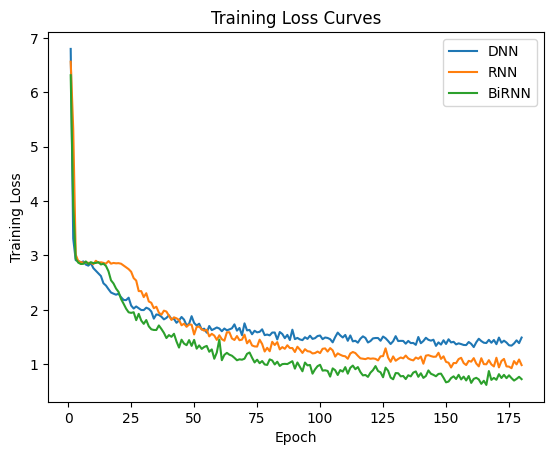

In [39]:
epochs = range(1, len(birnn_l) + 1)

# Plotting the loss curves
plt.plot(epochs, dnn_l, label='DNN')
plt.plot(epochs, rnn_l, label='RNN')
plt.plot(epochs, birnn_l, label='BiRNN')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves')
plt.legend()

# Show the plot
plt.show()

After 10 epochs with the same hyperparameters we can see, that 

| Model | WER    | CER      | Loss   | Parameters | Avg Duration of one epoch (train + test), s |
|-------|--------|----------|--------|------------|---------------------------------------------|
| DNN   | 0.9595 | 0.378508 | 1.2714 |   989 853  | 456.854
| RNN   | 0.7752 | 0.304076 | 1.0169 |  1 706 653 | 509.555
| BiRNN | 0.6071 | 0.215092 | 0.7266 |  3 349 149 | 526.033


- *WER / CER*: The BiRNN model outperforms both the DNN and RNN models in terms of WER and CER, indicating better accuracy in transcribing speech.

- *Training time*: The training time increases as the complexity of the model increases. The DNN model has the fewest parameters and the shortest training time, followed by the RNN and then the BiRNN model, which has the most parameters and the longest training time.

- *Training stability*: Training stability was inferred from the loss values. Lower loss values generally indicate better convergence, and the BiRNN model outperforms both the DNN and RNN models in terms of convergence. While fluctuations in the loss curve across epochs appear similar for all models, the DNN model may exhibit slightly fewer fluctuations.

Overall, based on the comparison provided, the BiRNN model appears to offer the best balance of accuracy (lower WER and CER) and complexity (number of parameters) among the three models tested. However, it comes at the cost of longer training time.

Here I trained BiRNN model till 0.3931 average WER.

In [33]:
def save_checkpoint(model, optimizer, checkpoint_name, path='./'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(path, checkpoint_name))


In [34]:
from torchmetrics.text import CharErrorRate, WordErrorRate

def test(model: nn.Module, device: str, test_loader: data.DataLoader, 
         criterion: nn.Module, epoch: int, decode: str = 'Greedy', lm: LanguageModel = None, 
         save_path: str = None, iteration: int = 0) -> None:
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer_metric = CharErrorRate()
    test_wer_metric = WordErrorRate()
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms, input_lengths)  # (batch, time, n_class)
            matrix = F.log_softmax(matrix, dim=2)
            probs = F.softmax(matrix,dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            if i == 3 and save_path is not None:
                np.savetxt(f"{save_path}_matrix_{iteration}.txt", probs[0].cpu().numpy())
                np.savetxt(f"{save_path}_labels_{iteration}.txt", labels[0].cpu().numpy())

            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = greedy_decoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                ## THIS IS THE FUNCTION YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = beam_search_decoder(probs, labels, label_lengths, input_lengths, lm=lm)
            
            # Update WER and CER metrics
            for j in range(len(decoded_preds)):
                test_wer_metric.update(decoded_preds[j], decoded_targets[j])
                test_cer_metric.update(decoded_preds[j], decoded_targets[j])

    avg_cer = test_cer_metric.compute()
    avg_wer = test_wer_metric.compute()
    wandb.log({'loss_test': test_loss, 'avg_cer': avg_cer, 'avg_wer': avg_wer})
    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:.4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))
    return 'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:.4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer)


In [24]:
# checkpoint_name = 'ctc_birnn.tar'

save_path = 'birnn'
hparams['epochs'] = 30

# Train a recurrent model
ctc_birnn = CTCBiRNN(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

optimizer = optim.AdamW(ctc_birnn.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=tokenizer.get_symbol_index(BLANK_SYMBOL), reduction='mean')
scheduler = OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=len(train_loader),
                       epochs=hparams['epochs'], anneal_strategy='linear')

# Load from a pretrained model if available
checkpoint_path = 'ctc_birnn_epoch12.tar'  # 12 because I had GPU memory crushed after 2 epochs of training
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    ctc_birnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

with open(f'{save_path}_train_log.txt', 'a') as f:
    for epoch in tqdm(range(13, hparams['epochs'] + 13)):
        t_s = time.time()
        logs = train(ctc_birnn, device, train_loader, criterion, optimizer, scheduler, epoch)
        print(*logs, file=f, sep='\n')
        save_checkpoint(ctc_birnn, optimizer, checkpoint_name=f'ctc_birnn_epoch{epoch}.tar')
        wandb.save(f'ctc_birnn_epoch{epoch}.tar')
        print('Beginning eval...', file=f)
        log_test = test(ctc_birnn, device, test_loader, criterion, epoch, decode='BeamSearch', save_path=save_path, iteration=epoch)
        print(log_test, file=f)
        t_e = time.time()
        duration = t_e - t_s
        print(f"BiRNN epoch {epoch}: Duration {duration:.2f} seconds")
        print(f"BiRNN epoch {epoch}: Duration {duration:.2f} seconds", file=f)

# Save the final model checkpoint
save_checkpoint(ctc_birnn, optimizer, checkpoint_name='ctc_birnn_final.tar')


Train Epoch: 13 [0/28539 (0%)]	Loss: 0.827306
Train Epoch: 13 [1600/28539 (6%)]	Loss: 0.687718
Train Epoch: 13 [3200/28539 (11%)]	Loss: 0.707489
Train Epoch: 13 [4800/28539 (17%)]	Loss: 0.616213
Train Epoch: 13 [6400/28539 (22%)]	Loss: 0.625248
Train Epoch: 13 [8000/28539 (28%)]	Loss: 0.622339
Train Epoch: 13 [9600/28539 (34%)]	Loss: 0.802156
Train Epoch: 13 [11200/28539 (39%)]	Loss: 0.675906
Train Epoch: 13 [12800/28539 (45%)]	Loss: 0.708587
Train Epoch: 13 [14400/28539 (50%)]	Loss: 0.654186
Train Epoch: 13 [16000/28539 (56%)]	Loss: 0.628897
Train Epoch: 13 [17600/28539 (62%)]	Loss: 0.686770
Train Epoch: 13 [19200/28539 (67%)]	Loss: 0.694705
Train Epoch: 13 [20800/28539 (73%)]	Loss: 0.622250
Train Epoch: 13 [22400/28539 (78%)]	Loss: 0.713999
Train Epoch: 13 [24000/28539 (84%)]	Loss: 0.701849
Train Epoch: 13 [25600/28539 (90%)]	Loss: 0.675724
Train Epoch: 13 [27200/28539 (95%)]	Loss: 0.686331
Beginning eval...
Epoch: 13, Test set: Average loss: 0.7064, Average CER: 0.2026 Average WER: 

## Compare alignments (3 points)

In this section you should compare alignments obtained from different models (DNN / RNN / BiRNN). For example, you can show:

- Examples of alignments and their analysis. 
- Differencies in the properties of alignment distributions over the dataset. 
- Dynamic of alignments during training (from checkpoints). 
- Connection between alignments and model loss. 
- Which models use the most blanks and why?

This task is very interesting, but it requires too much effort. I will do it later by myself after running and saving all the labels. Currently, I have only saved one label, which was mentioned in the test function. However, I need to save all the labels for all the checkpoints for all the models in order to compare them.

In [51]:
for i, _data in enumerate(test_loader):
    spectrograms, labels, input_lengths, label_lengths = _data
    if i == 3:
        print(labels[0])
        print(label_lengths)

tensor([ 3., 19., 16., 21.,  9.,  6., 19.,  1., 14.,  2.,  4.,  1.,  2., 19.,
         5., 13.,  6.,  1.,  3., 19., 16., 21.,  9.,  6., 19.,  1., 12.,  6.,
        16.,  8.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [52]:
Tokenizer().indices_to_text([ 3., 19., 16., 21.,  9.,  6., 19.,  1., 14.,  2.,  4.,  1.,  2., 19.,
         5., 13.,  6.,  1.,  3., 19., 16., 21.,  9.,  6., 19.,  1., 12.,  6.,
        16.,  8.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])

"brother mac ardle brother keogh'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''"

/tmp/ipykernel_37032/3681196360.py:26: RuntimeWarning: divide by zero encountered in log
  im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
/tmp/ipykernel_37032/3681196360.py:38: RuntimeWarning: divide by zero encountered in log
  im = ax[1,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
/tmp/ipykernel_37032/3681196360.py:50: RuntimeWarning: divide by zero encountered in log
  im = ax[2,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')


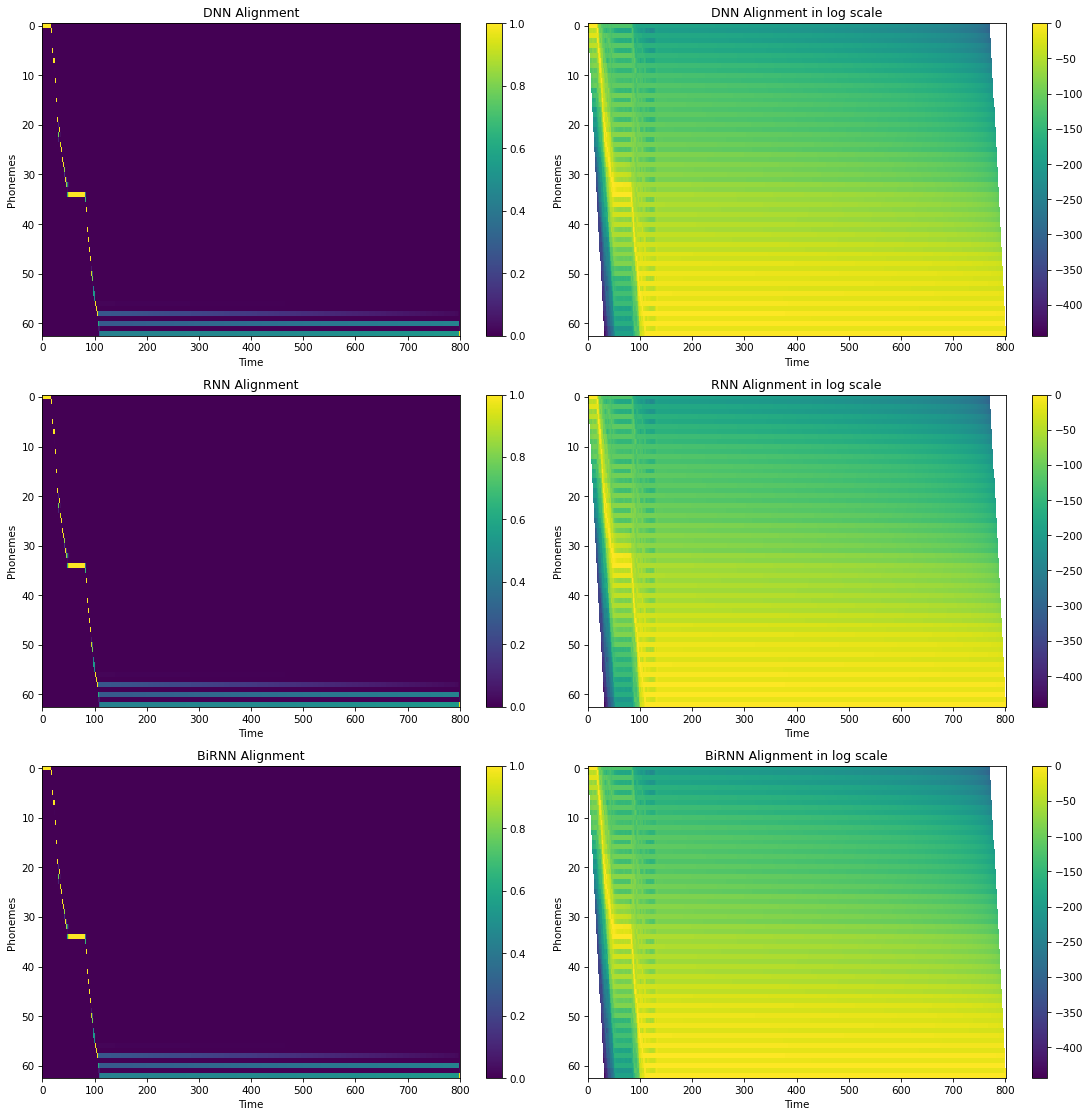

In [45]:
# Some code to get you started.
dnn_matrix = np.loadtxt('dnn_matrix.txt').T
rnn_matrix = np.loadtxt('rnn_matrix.txt').T
birnn_matrix = np.loadtxt('birnn_matrix.txt').T

dnn_labels = np.loadtxt('dnn_labels.txt', dtype=np.int32, converters=float)
dnn_labels = dnn_labels[dnn_labels != 0]
rnn_labels = np.loadtxt('rnn_labels.txt', dtype=np.int32, converters=float)
rnn_labels = rnn_labels[rnn_labels != 0]
birnn_labels = np.loadtxt('birnn_labels.txt', dtype=np.int32, converters=float)
birnn_labels = birnn_labels[birnn_labels != 0]

dnn_align = soft_alignment(dnn_labels, dnn_matrix)
rnn_align = soft_alignment(rnn_labels, rnn_matrix)
birnn_align = soft_alignment(birnn_labels, birnn_matrix)

f, ax = plt.subplots(3, 2, dpi=75, figsize=(15, 15))


im = ax[0,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[0,0].set_title("DNN Alignment")
ax[0,0].set_ylabel("Phonemes")
ax[0,0].set_xlabel("Time")
f.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[0,1].set_title("DNN Alignment in log scale")
ax[0,1].set_ylabel("Phonemes")
ax[0,1].set_xlabel("Time")
f.colorbar(im, ax=ax[0,1])

im = ax[1,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[1,0].set_title("RNN Alignment")
ax[1,0].set_ylabel("Phonemes")
ax[1,0].set_xlabel("Time")
f.colorbar(im, ax=ax[1,0])

im = ax[1,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[1,1].set_title("RNN Alignment in log scale")
ax[1,1].set_ylabel("Phonemes")
ax[1,1].set_xlabel("Time")
f.colorbar(im, ax=ax[1,1])

im = ax[2,0].imshow(dnn_align, aspect='auto', interpolation='nearest')
ax[2,0].set_title("BiRNN Alignment")
ax[2,0].set_ylabel("Phonemes")
ax[2,0].set_xlabel("Time")
f.colorbar(im, ax=ax[2,0])

im = ax[2,1].imshow(np.log(dnn_align), aspect='auto', interpolation='nearest')
ax[2,1].set_title("BiRNN Alignment in log scale")
ax[2,1].set_ylabel("Phonemes")
ax[2,1].set_xlabel("Time")
f.colorbar(im, ax=ax[2,1])

plt.tight_layout()

We can see that the alignments look very similar. There are some words at the beginning of the audio, followed by a prolonged period of silence, resulting in a wide alignment in log scale.